## Linear Methods 

In this section, we will perform linear regression with Lasso, Ridge and Forward Selection. 
Each time, we cross validate with 5 folds to get optimal parameters. Additionally, we perform the methods for 2 datasets : the full set of predictors (3028) and a subset of predictors (1195) which are less correlated ( < 0.95 correlation index).
A submission is made for Lasso and Ridge, whereas for the Forward Selection, it will be done after having done some feature engineering (see Regression.ipynb file).

In [1]:
#Loading of the training and test data
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [2]:
#Preperation of data as we have done in the Exploration
library(caret)

#VARIABLES
# x -> Dataframe with feature variables
# y -> Response variable only
# corr.x -> Dataframe with predictors with a correlation index below 0.95


#Searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#Attach Intensity as numeric for regression
x$Intensity <- as.numeric(train.data$Intensity) -1

#Response variable
y <- train.data$VALENCE.PLEASANTNESS

#Searching for input variables with correlation index below 0.95
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]

Loading required package: lattice
Loading required package: ggplot2


## Linear Regression with Lasso Regularization and 5-Fold Cross Validation

First, Lasso regularization method is used. This process aims at restricting the features while modelling to minimize the risk of overfitting. We will also test this method with both correlated and uncorrelated variables to see if we have a difference in the validation MSE. To answer this question, and as the results highly depend on the seed, we will perform this method multiple times (on 50 different seeds). Then, we will plot a result for the seed leading to the minimum validation MSE.

First, let's perform the Lasso Regularization for the seed 100 to 150. 

In [31]:
set.seed(1)
library(glmnet)

full.data.x = as.matrix(x)
full.data.y = as.matrix(y)

cv.lasso <- cv.glmnet(full.data.x, full.data.y, alpha = 1, nfold = 5)
best.lasso <- glmnet(full.data.x,full.data.y, alpha = 1, lambda = cv.lasso$lambda.min)

corr.cv.lasso <- cv.glmnet(as.matrix(corr.x), full.data.y, alpha = 1, nfold = 5)
corr.best.lasso <- glmnet(as.matrix(corr.x), full.data.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)

cat("The optimal lambda parameter for the full data is  ", cv.lasso$lambda.min, '\n')
cat("The optimal lambda parameter for the less correlated data is  ", corr.cv.lasso$lambda.min)

The optimal lambda parameter for the full data is   1.294689 
The optimal lambda parameter for the less correlated data is   1.235844

In [32]:
seeds = seq(100,150,1)

RMSE_ = c()
RMSE_corr = c()

#This loop aims at having a mean of validation errors on 50 different seeds instead of having it for only one seed. 
#It enables to compare the different models afterwards

for (i in seeds) {
    set.seed(i)
    #split the training data in a training set and a validation set for correlated data
    len <- length(x[,1])
    idx.train <- sample(1:len, 2*len/3)

    train.x <- as.matrix(x[idx.train,])
    train.y <- as.matrix(y[idx.train])
    val.x <- as.matrix(x[-idx.train,])
    val.y <- as.matrix(y[-idx.train])

    #split the training data in a training set and a validation set for uncorrelated data
    corr.train.x <- as.matrix(corr.x[idx.train,])
    corr.train.y <- as.matrix(y[idx.train])
    corr.val.x <- as.matrix(corr.x[-idx.train,])
    corr.val.y <- as.matrix(y[-idx.train])
    
    #Perform cross validation to find the optimal lambda on both sets
    #cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
    #corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
    
    #Perform Lasso with best lambda for both sets
    #best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
    pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = (val.x))
    #corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
    corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = (corr.val.x))

    #Compute RMSE with best lasso prediction 
    RMSE_ = rbind(RMSE_, sqrt(mean((pred - val.y)^2)))
    RMSE_corr = rbind(RMSE_corr, sqrt(mean((corr.pred - corr.val.y)^2)))
    
}

In [33]:
mean.RMSE_ = mean(RMSE_)
mean.RMSE_corr = mean(RMSE_corr)
#mean.RMSE_corr = mean(RMSE_corr)
cat("The validation MSE for the 3028 predictors (with correlations) is ", mean.RMSE_, "and variance ", var(RMSE_), '\n')
cat("The validation MSE for the 1195 predictors (with less correlations) is ", mean.RMSE_corr, "and variance ", var(RMSE_corr))

The validation MSE for the 3028 predictors (with correlations) is  20.44124 and variance  0.6008932 
The validation MSE for the 1195 predictors (with less correlations) is  20.36493 and variance  0.5978282

We can see that we get really similar results with correlated and uncorrelated data, with a slight decrease for the set of predictors that are less correlated. Therefore, we will continue to test the uncorrelated data since it has less dimensions.


In [41]:
seed.min.corr = which.min(RMSE_corr) #35
min.error.corr = RMSE_corr[seed.min.corr] #seed = 135 ; #error = 415

The seed that resulted in the minimum validation MSE is the seed number 135.

In [35]:
#Perform a Lasso Reg with the best seed
set.seed(135)

library(glmnet)

len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])


In [36]:
#5-fold cross-validation to find the optimal value for the parameter lambda
corr.cv.lasso.135 <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)

[1] "Plot for Lasso on less correlated data "


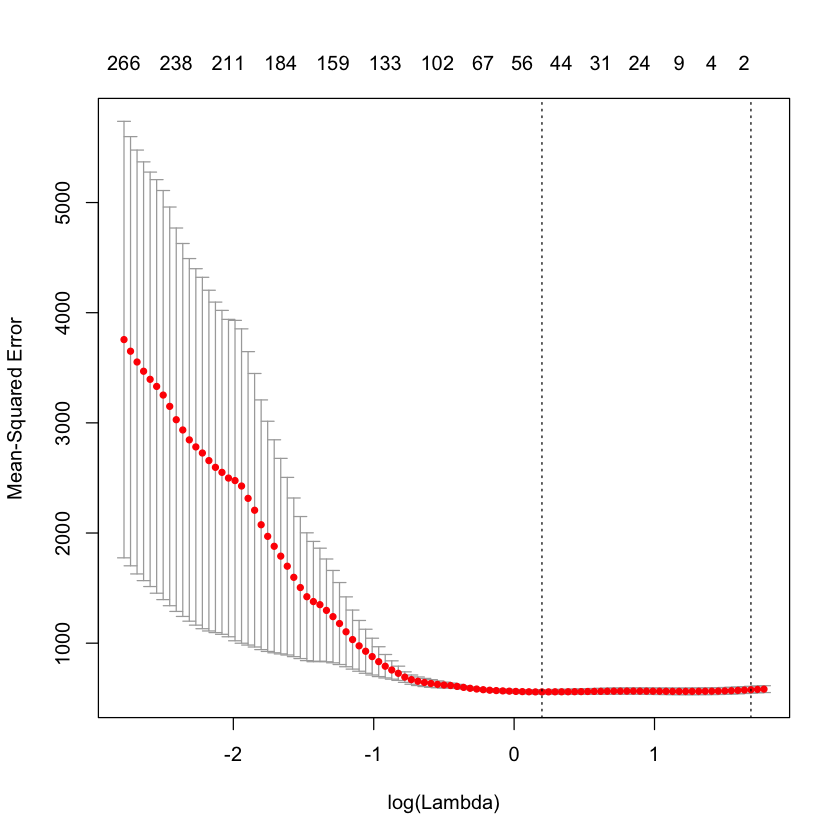

In [37]:
#PLOT FOR LESS CORRELATED DATA
print("Plot for Lasso on less correlated data ")
plot(corr.cv.lasso.135)

In [38]:
corr.best.lasso.135 <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso.135$lambda.min)
corr.pred.135 <- predict(corr.best.lasso.135, s = corr.cv.lasso.135$lambda.min, newx = as.matrix(corr.val.x))
 
cat("The validation MSE is : ", mean((corr.pred.135 - corr.val.y)^2))

The validation MSE is :  413.4438

## Submission for Lasso Regularization

In [ ]:
set.seed(135)
library(glmnet)


len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])

corr.cv.lasso.135 <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
corr.best.lasso.135 <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso.135$lambda.min)

In [21]:
#preparation of test data
test.x <- test.data[,-c(1,2)]
test.x <- test.x[,!idx.zero.var]
test.x$Intensity <- as.numeric(test.data$Intensity) -1
test.x <- test.x[, -which(colnames(x) %in% highlyCorrCol)]
test.x <- as.matrix(test.x)
#Make prediction for sumbission
VALENCE.PLEASANTNESS <- predict(corr.best.lasso.135, s = corr.best.lasso.135$lambda.min, newx = (test.x))

In [22]:
#Creation of csv submission-file
submission <- data.frame(Id = 1:68, VALENCE.PLEASANTNESS = VALENCE.PLEASANTNESS)
names(submission) <- c("Id", "VALENCE.PLEASANTNESS")
write.csv(submission, file = "../Submissions/lasso_135.csv", row.names = FALSE)

## Linear Regression with Ridge Regularization and 5-Fold Cross Validation

We will try another regularization method, which instead of making estimated coefficients to absolute zero (Lasso), shrinks them. Again, we will perform it for 50 different seeds (splits) to have an estimation of the variance of the model and a more accurate estimate of the validation errors.

In [43]:
set.seed(1)
library(glmnet)

full.data.x = as.matrix(x)
full.data.y = as.matrix(y)

cv.ridge <- cv.glmnet(full.data.x, full.data.y, alpha = 0, nfold = 5)
best.ridge <- glmnet(full.data.x,full.data.y, alpha = 0, lambda = cv.ridge$lambda.min)

corr.cv.ridge <- cv.glmnet(as.matrix(corr.x), full.data.y, alpha = 0, nfold = 5)
corr.best.ridge <- glmnet(as.matrix(corr.x), full.data.y, alpha = 0, lambda = corr.cv.ridge$lambda.min)

cat("The optimal lambda parameter for the full data is  ", cv.ridge$lambda.min, '\n')
cat("The optimal lambda parameter for the less correlated data is  ", corr.cv.ridge$lambda.min)

The optimal lambda parameter for the full data is   152.3606 
The optimal lambda parameter for the less correlated data is   95.68688

In [46]:
seeds = seq(100,150,1)

RMSE_ = c()
RMSE_corr = c()

#This loop aims at having a mean of validation errors on 50 different seeds instead of having it for only one seed. 
#It enables to compare the different models afterwards

for (i in seeds) {
    set.seed(i)
    #split the training data in a training set and a validation set for correlated data
    len <- length(x[,1])
    idx.train <- sample(1:len, 2*len/3)

    train.x <- as.matrix(x[idx.train,])
    train.y <- as.matrix(y[idx.train])
    val.x <- as.matrix(x[-idx.train,])
    val.y <- as.matrix(y[-idx.train])

    #split the training data in a training set and a validation set for uncorrelated data
    corr.train.x <- as.matrix(corr.x[idx.train,])
    corr.train.y <- as.matrix(y[idx.train])
    corr.val.x <- as.matrix(corr.x[-idx.train,])
    corr.val.y <- as.matrix(y[-idx.train])
    
    #Perform cross validation to find the optimal lambda on both sets
    #cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
    #corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
    
    #Perform Lasso with best lambda for both sets
    #best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
    pred <- predict(best.ridge, s = cv.ridge$lambda.min, newx = (val.x))
    #corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
    corr.pred <- predict(corr.best.ridge, s = corr.cv.ridge$lambda.min, newx = (corr.val.x))

    #Compute RMSE with best lasso prediction 
    RMSE_ = rbind(RMSE_, sqrt(mean((pred - val.y)^2)))
    RMSE_corr = rbind(RMSE_corr, sqrt(mean((corr.pred - corr.val.y)^2)))
    
}

In [47]:
mean.RMSE_ = mean(RMSE_)
mean.RMSE_corr = mean(RMSE_corr)
#mean.RMSE_corr = mean(RMSE_corr)
cat("The validation MSE for the 3028 predictors (with correlations) is ", mean.RMSE_, "and variance ", var(RMSE_), '\n')
cat("The validation MSE for the 1195 predictors (with less correlations) is ", mean.RMSE_corr, "and variance ", var(RMSE_corr))

The validation MSE for the 3028 predictors (with correlations) is  20.40732 and variance  0.5461573 
The validation MSE for the 1195 predictors (with less correlations) is  20.94906 and variance  0.5677908

In [50]:
seed.min.corr = which.min(RMSE_corr) #45
min.error.corr = RMSE_corr[seed.min.corr] #seed = 146 ; #error = 420.9 


[1] 19.48894

[1] 36

[1] "Plot for Ridge on less correlated data "


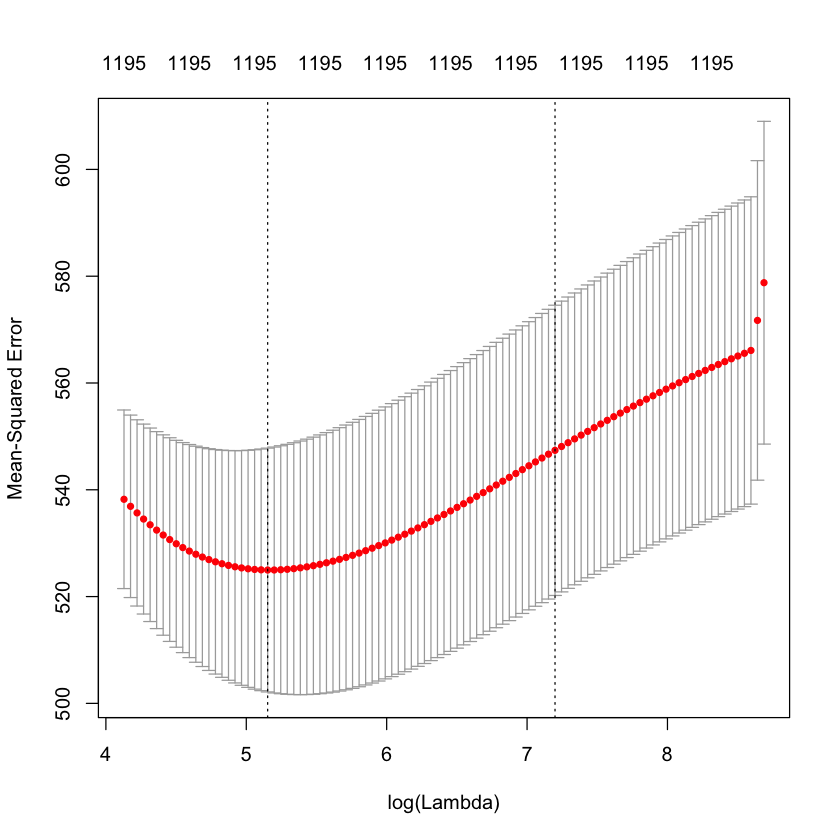

In [52]:
set.seed(135)

#split the training data in a training set and a validation set for correlated data
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

#split the training data in a training set and a validation set for uncorrelated data
corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])

corr.cv.ridge.135 <- cv.glmnet(corr.train.x, corr.train.y, alpha = 0, nfold = 5)

#PLOT FOR LESS CORRELATED DATA
print("Plot for Ridge on less correlated data ")
plot(corr.cv.ridge.135)

In [55]:
#best prediction for uncorrelated
corr.best.ridge.135 <- glmnet(corr.train.x, corr.train.y, alpha = 0, lambda = corr.cv.ridge.135$lambda.min)
corr.pred.135 <- predict(corr.best.ridge.135, s = corr.cv.ridge.135$lambda.min, newx = corr.val.x)

#MSE with best lasso prediction 
cat("The validation MSE is : ", mean((corr.pred.135 - corr.val.y)^2))

The validation MSE is :  435.1496

On average, the Ridge Regression seems to have a smaller validation MSE than Lasso. Still, the values are really similar and we can say that the two methods have similar performances. 

Additionally, we still see that on average, the validation MSE with less correlated predictors is lower than the full set. It confirms the results obtained in Lasso. 

Now we will try stepwise feature selection. Stepwise regression is a method of fitting regression models in which the choice of predictive variables is carried out by an automatic procedure. 
We will do the Forward Selection technique 

## Forward Selection with 5-Fold Cross-Validation

In [21]:
set.seed(100)

library(tidymodels)
library(leaps)

#functions 
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}


evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y
validation.data <- vfold_cv(full.data, v = 5)           
           
cv.errors <- sapply(validation.data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2715  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2706  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2706  linear dependencies found"


Reordering variables and trying again:


We obtained a validation MSE =  502.0011  for  9  predictors

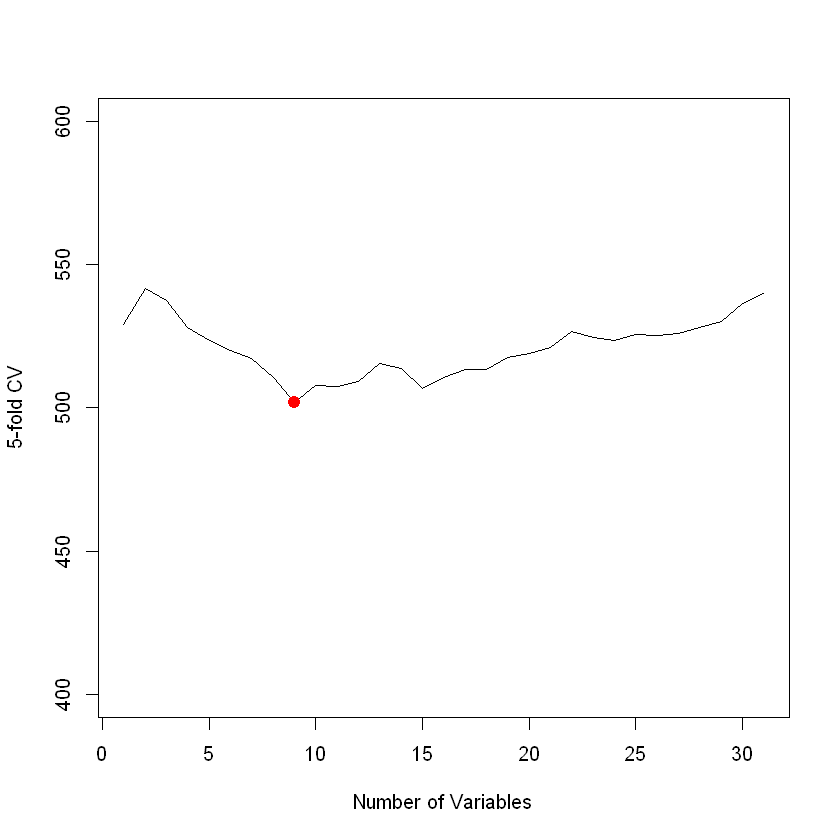

In [22]:
#plot the obtained data
plot(mean.cv.errors, type = "l", ylim = c(400, 600), xlab = "Number of Variables", ylab = "5-fold CV")
cv.min <- which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(full.data$VALENCE.PLEASANTNESS), 0, lty = "dashed")

cat("We obtained a validation MSE = ", mean.cv.errors[cv.min], " for ", which.min(mean.cv.errors), " predictors")

We can see that the best predictions are obtained with a small number of variables (9 variables). 